**Attrition refers to the number or percentage of employees who are leaving a company to work for other companies or who have decided to pursue other opportunities. The attrition rate is the measurement you use to determine the percentage of employees who have left a company in a given period.**

![](https://i2.wp.com/thecontextofthings.com/wp-content/uploads/2017/01/employee-attrition.jpg?resize=300%2C300)

# Here we will try to apply various machine learning algorithms and getting the important features which are impacting attrition the most. 

For this purpose, I will be using 5 algorithms and then will check the accuracy score and most important features. 


| Algorithm Name |     Handles missing data ? |    Feature Scaling Required?     | Outliers Sensitive ? | 
| --- | --- | --- | --- |
| Decision Tree | Yes | No | No | 
| Random Forest | Yes | No | No |
| SVM    | No | Yes | Yes | 
| KNN |  No | Yes | Yes | 
| Naive Bayes | Yes(by ignoring them) | No | Yes | 



> I tried to consolidate some facts about these algorithms. Feel free to provide any suggestion regarding the above points. 

In [ ]:
#import libraries

import os
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.pipeline import Pipeline

#import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#import preprocessing libraries
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score

#import dimensionality reduction libraries
from sklearn.decomposition import PCA

#import algorithm libraries
from sklearn.linear_model import LogisticRegression, SGDClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

#import error metrics
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score


In [ ]:
#get the path of the dataset

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [ ]:
data = pd.read_csv('/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(data.shape)
data.head()

In [ ]:
data.describe()

In [ ]:
data.info()

# Lets do some EDA

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title='Pandas Profiling Report')

In [ ]:
profile.to_widgets()

# From Pandas Profiler, we got few interesting points:

1. MonthlyIncome is highly correlated with JobLevel.
2. JobRole is highly correlated with Department
3. Attrition property has 1233 as No value and 237 as Yes. Which means that 237 people left the company. 

**We will now check the outliers.** 

In [ ]:
# Create a function to detect outliers
def detect_outliers(df,n,features):
    # create a array to store the values of outliers
    outliers_index = []
    
    # calculate the Q1 and Q3. Then we can calculate IQR
    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        #outlier step
        outlier_step = 1.5 * IQR
        
        # Determine the indices of outliers in a particular column
        outlier_list_col = df[(df[col] < (Q1 - outlier_step))|(df[col] > (Q3 + outlier_step))].index
        
        # append the found outlier indices for col to the list of outlier indices
        outliers_index.extend(outlier_list_col)
        
        # select observations containing more than 2 outliers
        outliers_index = Counter(outliers_index)
        multiple_outliers = list( k for k, v in outliers_index.items() if v > n )
        
        return multiple_outliers

In [ ]:
detect_outliers(data,2,['DailyRate', 'DistanceFromHome','YearsAtCompany','YearsWithCurrManager',
                        'EmployeeNumber','JobInvolvement','PercentSalaryHike'])

**So till now we have checked that there is no null value or no outliers.**

# Now we will check the feature selection

![Image Source: machinelearningmastery](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png)

In [ ]:
# since our output is categorical, we will try with chi-squared (chi²) statistical test first

from sklearn.feature_selection import SelectKBest, chi2,f_classif

# Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

# apply label encoder to all the categorical columns
data_copy = data.copy()
le = LabelEncoder()
for col in object_cols:
    data_copy[col] = le.fit_transform(data_copy[col].astype(str))
   
 # get the x and y value
xl,yl = data_copy.drop(columns = 'Attrition'), data_copy['Attrition']
    
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
dfit = bestfeatures.fit(xl,yl)
df_scores = pd.DataFrame(dfit.scores_)
df_cols = pd.DataFrame(xl.columns)
# now we will concatenate the 2 dataframes
feature_importance = pd.concat([df_cols, df_scores],axis=1)
feature_importance.columns = ['Feature','Score']
print(feature_importance.nlargest(20,'Score'))

Since we know that the Chi2 test is for finding correlation between 2 categorical values. So we will check only for categorical features. 

In [ ]:
# now we will check with ANOVA test. If the features are quantitative, compute the ANOVA F-value 
# between each feature and the target vector.

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_classif, k=10)
dfit = bestfeatures.fit(xl,yl)
df_scores = pd.DataFrame(dfit.scores_)
df_cols = pd.DataFrame(xl.columns)
# now we will concatenate the 2 dataframes
feature_importance = pd.concat([df_cols, df_scores],axis=1)
feature_importance.columns = ['Feature','Score']
print(feature_importance.nlargest(10,'Score'))

# Now we will Encode our object columns and then will apply different models. 

In [ ]:
# Get list of categorical columns
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

# apply label encoder to all the categorical columns
data_copy = data.copy()
le = LabelEncoder()
for col in object_cols:
    data_copy[col] = le.fit_transform(data_copy[col].astype(str))
    
 # get the x and y value
x,y = data_copy.drop(columns = 'Attrition'), data_copy['Attrition']    

**Lets split the data using StratifiedKFold**

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state= 142)
for train_index, val_index in skf.split(x,y):
    train_x, val_x = x.iloc[train_index], x.iloc[val_index]
    train_y, val_y = y.iloc[train_index], y.iloc[val_index]
    
train_x.shape, val_x.shape    

# Lets start with DesisionTreeClassifier

Important Terminologies related to Decision Tree:

1. criterion: optional (default=”gini”) or Choose attribute selection measure: This parameter allows us to use the different-different attribute selection measure. Supported criteria are “gini” for the Gini index and “entropy” for the information gain.

2. splitter: string, optional (default=”best”) or Split Strategy: This parameter allows us to choose the split strategy. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

3. max_depth: int or None, optional (default=None) or Maximum Depth of a Tree: The maximum depth of the tree. If None, then nodes are expanded until all the leaves contain less than min_samples_split samples. The higher value of maximum depth causes overfitting, and a lower value causes underfitting. 

In Scikit-learn, optimization of decision tree classifier performed by only pre-pruning. The maximum depth of the tree can be used as a control variable for pre-pruning.

In [ ]:
dtc_model = DecisionTreeClassifier(criterion="entropy", max_depth=67)

# Train Decision Tree Classifer
dtc_model.fit(train_x,train_y)

#Predict the response for validation dataset
y_pred = dtc_model.predict(val_x)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(val_y, y_pred))

In [ ]:
#create a function to get the importance of features

def feat_imp(model, data, text):
    importances = model.feature_importances_
    
    #sort features in decreasing order of their importance
    indices = np.argsort(importances)[::-1]
    
    # Rearrange feature names so they match the sorted feature importances
    names = [data.columns[i] for i in indices]
    
    # Create plot
    plt.figure(figsize=(14,6))

    # Create plot title
    plt.title(text)

    # Add bars
    plt.bar(range(train_x.shape[1]), importances[indices])

    # Add feature names as x-axis labels
    plt.xticks(range(train_x.shape[1]), names, rotation=90)

    # Show plot
    plt.show()

In [ ]:
feat_imp(dtc_model,data, "Feature Importance for Decision Tree")

# Lets discuss Random Forest:

The random forest approach is a bagging method where deep trees, fitted on bootstrap samples, are combined to produce an output with lower variance.

* n_estimators = number of trees in the foreset
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)

In [ ]:
rfc_model = RandomForestClassifier()

rfc_model.fit(train_x,train_y)

#Predict the response for validation dataset
y_pred = rfc_model.predict(val_x)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(val_y, y_pred))

In [ ]:
feat_imp(rfc_model,data, "Feature Importance for Random Forest Classifier")

# Support Vector Machines Classifier: 

The core idea of SVM is to find a maximum marginal hyperplane(MMH) that best divides the dataset into classes. 

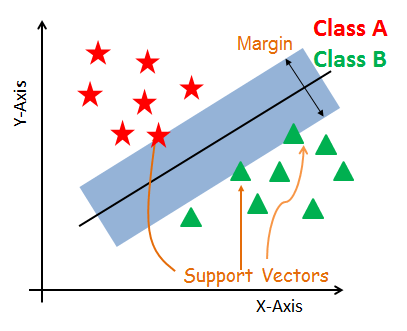

**Hyperparameters: **

* Kernel: The main function of the kernel is to transform the given dataset input data into the required form.
* Regularization: Regularization parameter in python's Scikit-learn C parameter used to maintain regularization. Here C is the penalty parameter, which represents misclassification or error term.
* Gamma: A lower value of Gamma will loosely fit the training dataset, whereas a higher value of gamma will exactly fit the training dataset, which causes over-fitting.

In [ ]:
svc_model = SVC(kernel='linear')

svc_model.fit(train_x,train_y)

#Predict the response for validation dataset
y_pred = svc_model.predict(val_x)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(val_y, y_pred))

The feature importance of linear SVMs could be found out but not for a nonlinear SVMs, the reason being that, when the SVM is non-linear the dataset is mapped into a space of higher dimension, which is quite different from the parent dataset and the hyperplane is obtained and this high dimensional data and hence the property is changed from that of the parent dataset and hence it is not possible to find the feature importance of this SVM in relation to the parent dataset features.

Reference: https://stackoverflow.com/questions/41628264/how-to-determine-feature-importance-of-non-linear-kernals-in-svm

Also we don't have direct method like feature_importances_ just like other Tree Algorithms. 

# Let's discuss KNN

KNN works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).

In [ ]:
knn_model = KNeighborsClassifier()

knn_model.fit(train_x,train_y)

#Predict the response for validation dataset
y_pred = knn_model.predict(val_x)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(val_y, y_pred))

Similar to SVM, feature importance is not defined for the KNN Classification algorithm.

# Now we will check with Naive Bayes

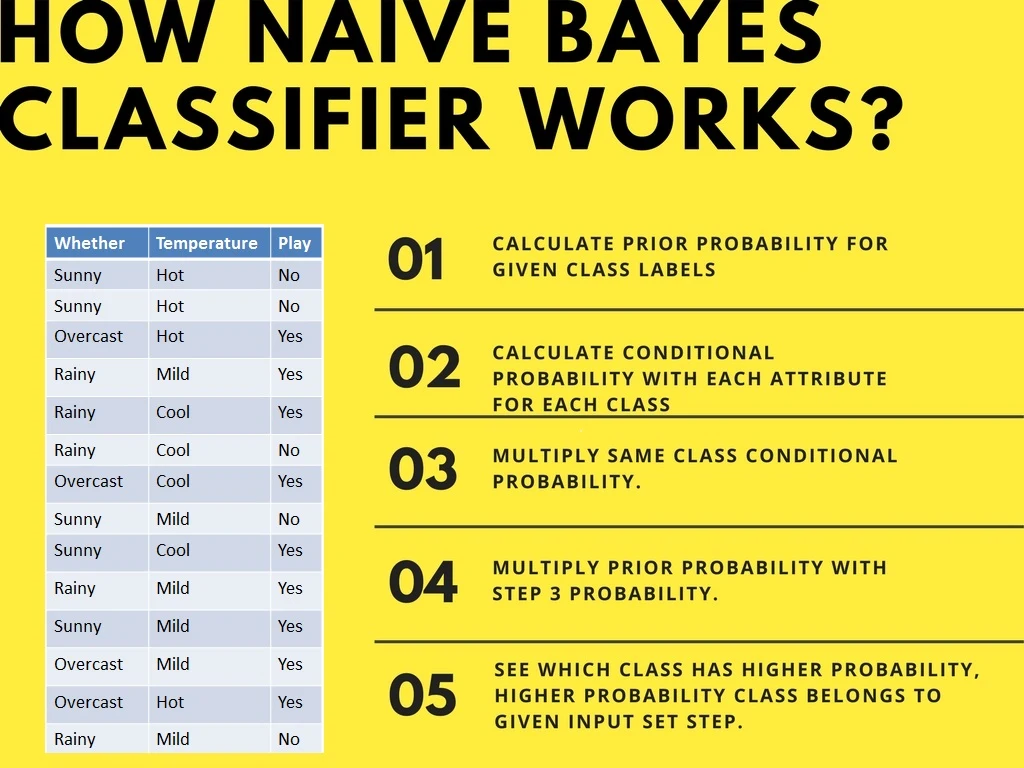

In [ ]:
nb_model = GaussianNB()

nb_model.fit(train_x,train_y)

#Predict the response for validation dataset
y_pred = nb_model.predict(val_x)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(val_y, y_pred))

Since Naive Bayes assumes independence and outputs class probabilities most feature importance criteria are not a direct fit. 

# Conclusion: 

We can see that the Random Forest is performing better than other classification algorithms. 

> So we will check the top 5 features impacting the Attrition Rate:

1. MaritalStatus
2. Age
3. BusinessTravel
4. Over18
5. EmployeeCount